# POBRANIE DATASETU

In [1]:
import numpy as np
import pandas as pd

In [2]:
import gdown
import zipfile
import os

file_id = "1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw"
output = "butterflies_zip.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# unziiping
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("butterflies")

os.listdir("butterflies")


Downloading...
From (original): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw
From (redirected): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw&confirm=t&uuid=097fde84-358a-4992-a576-69cd0eb21a80
To: /content/butterflies_zip.zip
100%|██████████| 237M/237M [00:02<00:00, 80.4MB/s]


['Testing_set.csv', 'Training_set.csv', 'test', 'train']

# EKSPLORACJA DATASETU

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3


In [3]:
df = pd.read_csv("butterflies/Training_set.csv")
df.head(5)

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [ ]:
df.shape

(6499, 2)

In [ ]:
len(df.label.unique()) #klasy

75

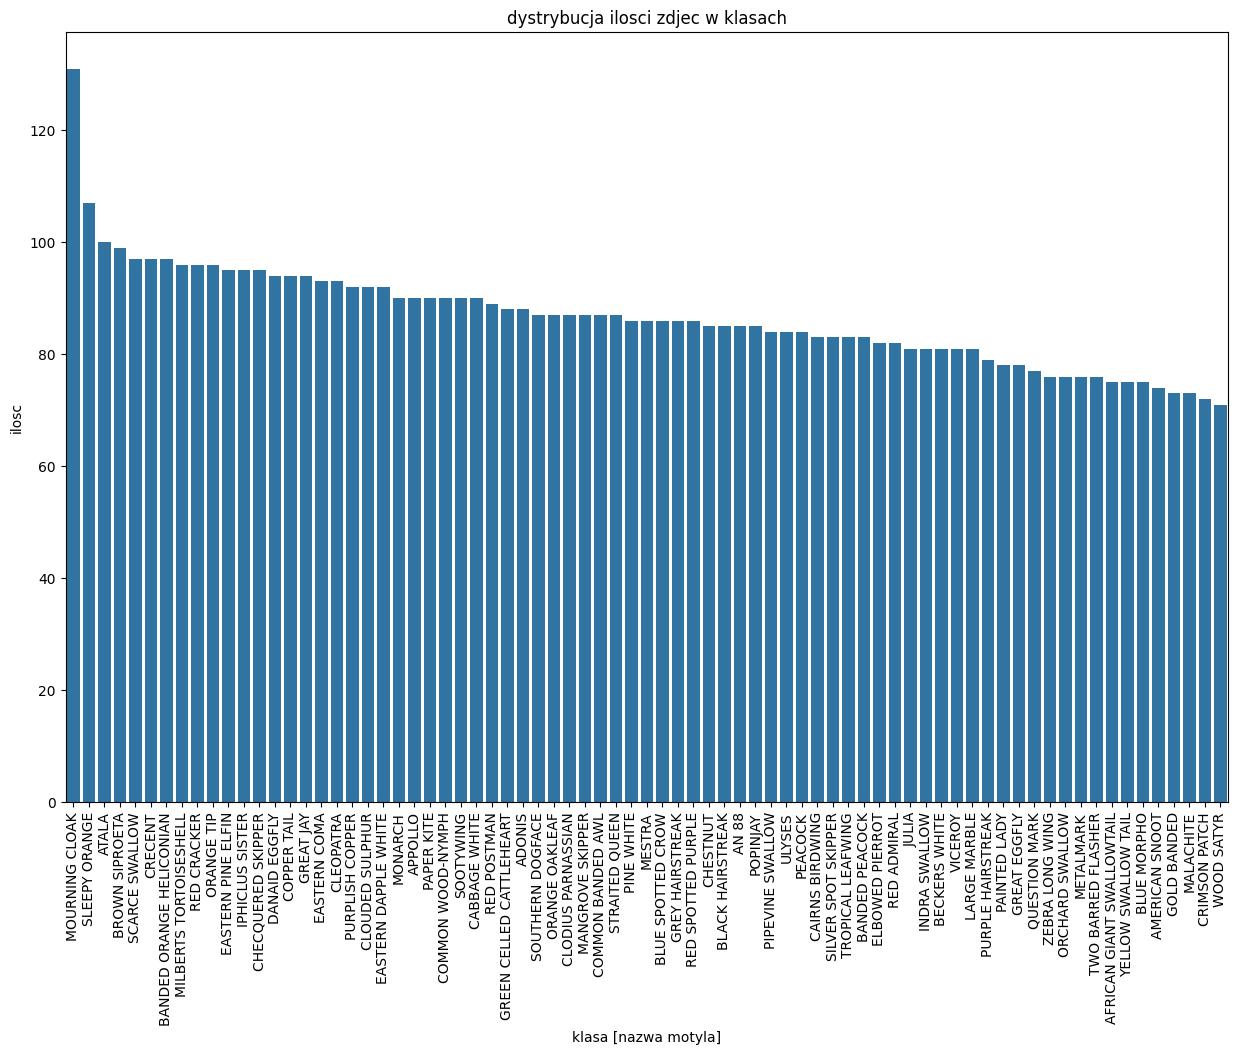

In [ ]:
label_distribution = df['label'].value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('dystrybucja ilosci zdjec w klasach')
plt.xlabel('klasa [nazwa motyla]')
plt.ylabel('ilosc')
plt.xticks(rotation=90)
plt.show()

# Trenowanie modelu na sieci ResNet50 od zera (bez transfer learningu) na CPU

In [5]:
train_dir = r'butterflies/train'
test_dir = r'butterflies/test'

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

img_gen = ImageDataGenerator()

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


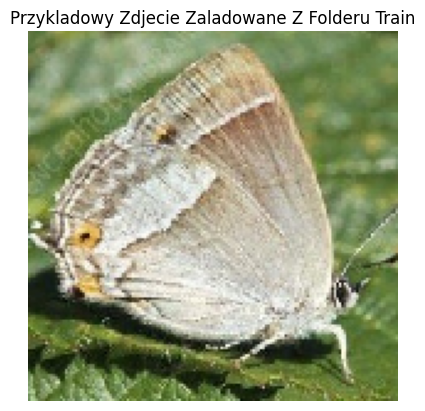

In [7]:
def sample_image():
  images, labels = next(train)

  plt.imshow(images[2].astype(np.uint8))
  plt.title(f"Przykladowy Zdjecie Zaladowane Z Folderu Train")
  plt.axis('off')
  plt.show()

sample_image()

In [8]:
train[0] #rgb wartosci zdjec;; przed normalizacją od 1 do 255

(array([[[[208., 168., 107.],
          [166., 145.,  92.],
          [186., 169., 123.],
          ...,
          [178., 147., 101.],
          [173., 141.,  92.],
          [143., 113.,  61.]],
 
         [[229., 187., 129.],
          [ 85.,  57.,   9.],
          [ 78.,  55.,  13.],
          ...,
          [189., 159., 123.],
          [192., 162., 124.],
          [166., 137.,  97.]],
 
         [[235., 194., 140.],
          [ 77.,  46.,   0.],
          [ 71.,  45.,   8.],
          ...,
          [190., 161., 129.],
          [192., 163., 131.],
          [161., 132.,  98.]],
 
         ...,
 
         [[237., 183., 159.],
          [215., 163., 126.],
          [230., 179., 136.],
          ...,
          [228., 177., 120.],
          [252., 201., 144.],
          [223., 177., 117.]],
 
         [[235., 190., 171.],
          [222., 176., 150.],
          [190., 146., 111.],
          ...,
          [254., 203., 148.],
          [243., 192., 137.],
          [249., 205., 142.

In [9]:
def plot_training_history(history):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [11]:
class_count = len(train.class_indices)
class_count

75

In [12]:
img_height = 150
img_width = 150

In [26]:
base_model = ResNet50(include_top=False,
                      weights=None,
                      classes=class_count)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,741,387 (90.57 MB)

 Trainable params: 23,688,267 (90.36 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 328ms/step - accuracy: 0.0540 - loss: 5.0864 - val_accuracy: 0.0200 - val_loss: 4.9036
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.1749 - loss: 3.2343 - val_accuracy: 0.2031 - val_loss: 3.6662
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.2981 - loss: 2.5523 - val_accuracy: 0.2262 - val_loss: 4.5074
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.4182 - loss: 2.1044 - val_accuracy: 0.1908 - val_loss: 7.3329
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.5218 - loss: 1.6615 - val_accuracy: 0.3131 - val_loss: 3.1799
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.5968 - loss: 1.3639 - val_accuracy: 0.3692 - val_loss: 2.7674
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.6463 - loss: 1.1601 - val_accuracy: 0.0269 - val_loss: 37.8747
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.6781 - loss:

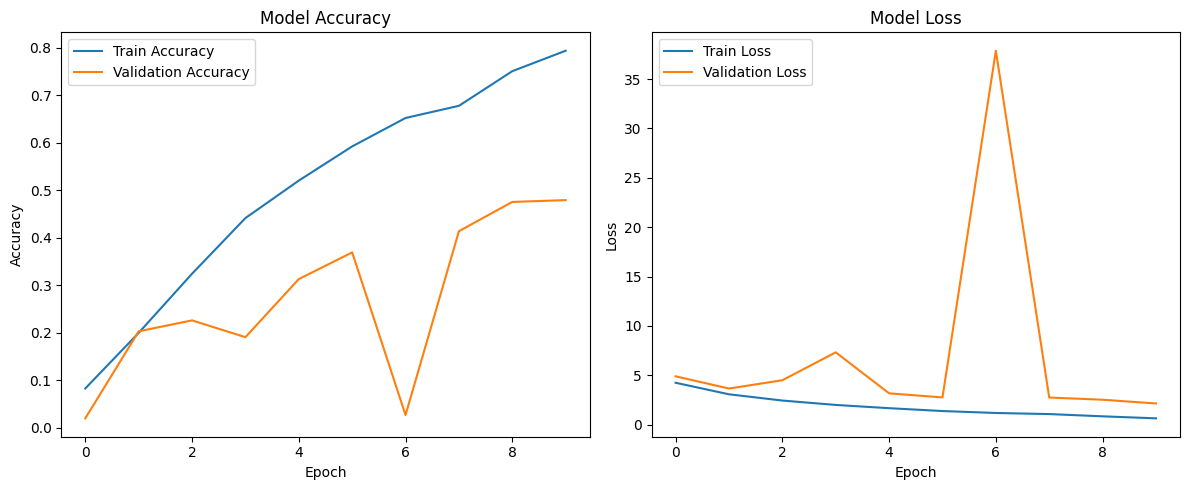

In [30]:
plot_training_history(history)

## CPU
CZAS: 1 EPOKA PONAD GODZINĘ; ŁĄCZNIE OKOŁO 10 H.

WYNIK: ...

## T4
CZAS: 7 MINUT

WYNIK [ACCURACY]: 80%

Z tak dużym dataset'em nie da się fizycznie odpalić tego modelu na CPU, zajęło by to możliwie z ponad 10 godzin.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


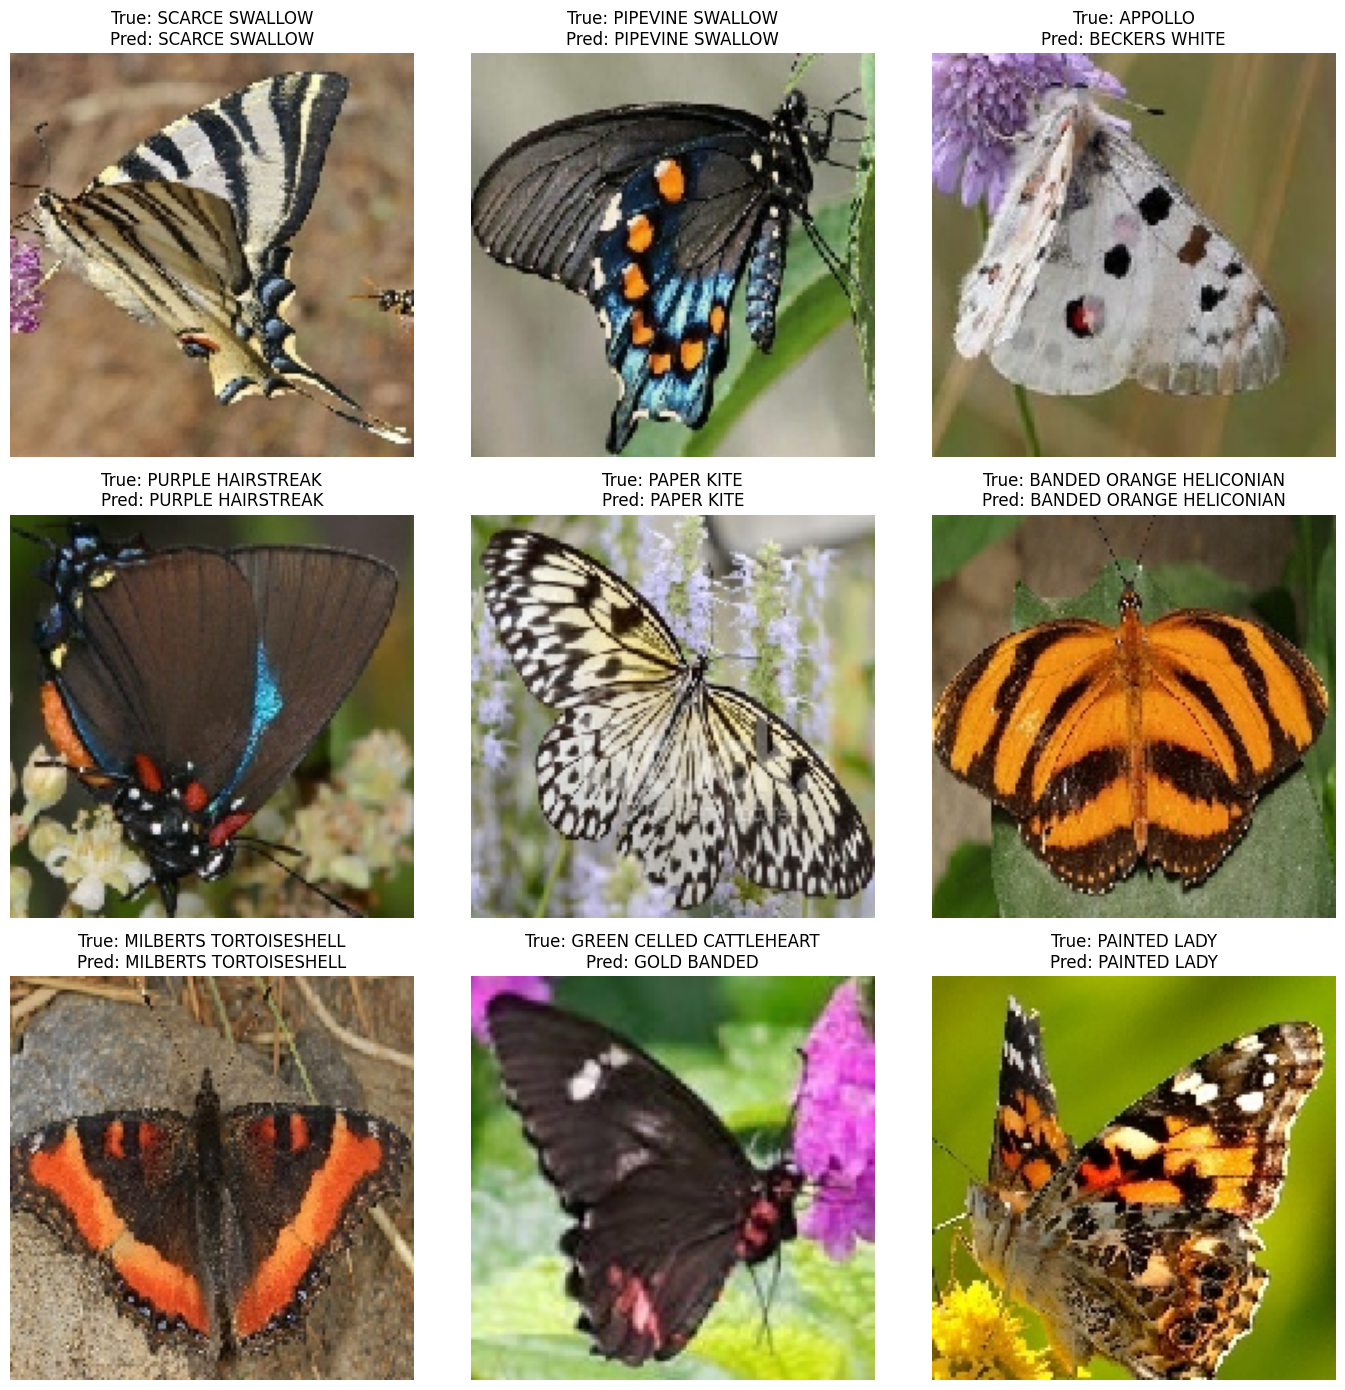

In [31]:
val_images, val_labels = next(validation)

pred_labels = model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = validation.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(14, 14))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

## TRANSFER LEARNING

In [ ]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy']) #model za szybko się uczył i dochodził do sufitu przy 5 epoce więc zmniejszam learning rate

In [ ]:
history_tl = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.0183 - loss: 5.1327 - val_accuracy: 0.0669 - val_loss: 4.0543
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.1267 - loss: 3.6950 - val_accuracy: 0.2269 - val_loss: 3.1463
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.3274 - loss: 2.8204 - val_accuracy: 0.3792 - val_loss: 2.5318
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4848 - loss: 2.2180 - val_accuracy: 0.4915 - val_loss: 2.1103
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5885 - loss: 1.8019 - val_accuracy: 0.5615 - val_loss: 1.8112
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6611 - loss: 1.5032 - val_accuracy: 0.6046 - val_loss: 1.6038
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7187 - loss: 1.3045 - val_accuracy: 0.6531 - val_loss: 1.4483
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7606 - loss: 1.1313 - 

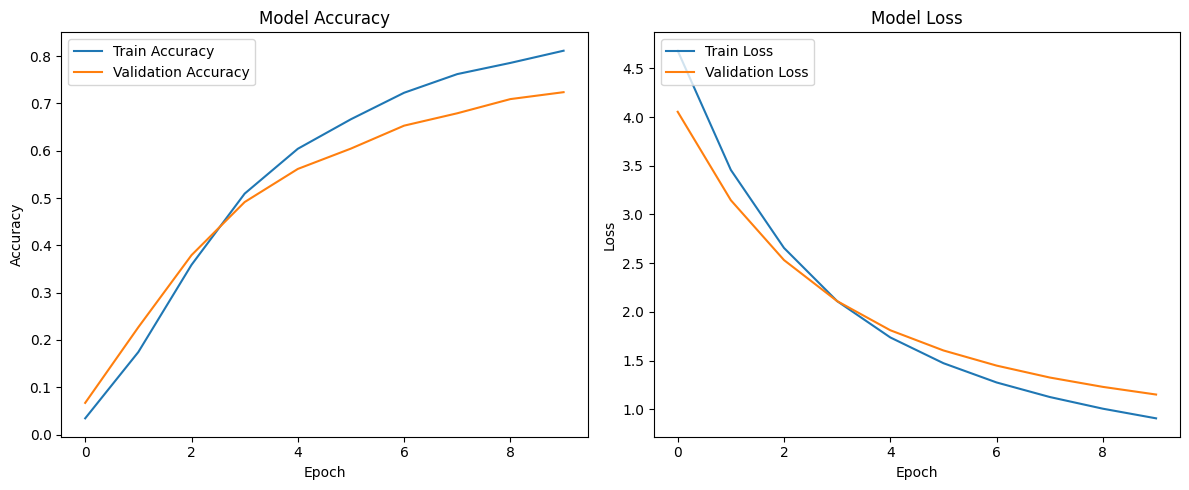

In [ ]:
plot_training_history(history_tl)

### TRANSFER LEARNING REPORT:

#### CZAS:
Jeden step zajmuje między 50-100ms gdy poprzednio zajmował 180-300ms

Samo trenowanie na T4 zajęło minutę; bez transfer learningu na T4 około 7 minut.

#### WYNIKI:
80% dokładności; bez transfer learningu wynosiło 80%.

Jednak różnią się diametralnie wykresami;

Dokładność walidacyjna jest dużo wyższa niż poprzednio i jest ona stabilna.

Straty tak samo dużo stabilniej wyglądają oraz nie skaczą; stopniowo się zmniejszają.


# OPTYMALIZACJA


## a. normalizację - przygotować raport porównawczy z normalizacją danych i bez.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

img_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input # normalizacja!
        )

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


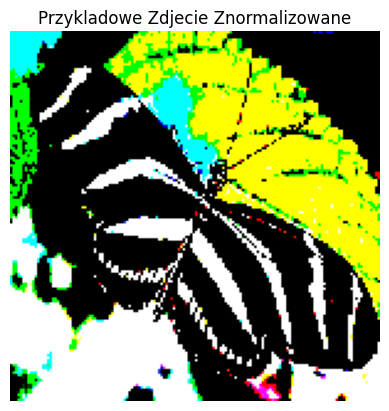

In [ ]:
def sample_image():
    images, labels = next(train)
    plt.imshow(images[2])
    plt.title("Przykladowe Zdjecie Znormalizowane")
    plt.axis('off')
    plt.show()

sample_image()

In [61]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [62]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_tl_nor = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.0271 - loss: 5.0012 - val_accuracy: 0.0985 - val_loss: 3.8531
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.1823 - loss: 3.4304 - val_accuracy: 0.3262 - val_loss: 2.8761
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.4207 - loss: 2.5311 - val_accuracy: 0.4854 - val_loss: 2.2358
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5790 - loss: 1.9303 - val_accuracy: 0.5808 - val_loss: 1.8160
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.6877 - loss: 1.5255 - val_accuracy: 0.6431 - val_loss: 1.5310
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7441 - loss: 1.2555 - val_accuracy: 0.6854 - val_loss: 1.3378
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8029 - loss: 1.0472 - val_accuracy: 0.7246 - val_loss: 1.1917
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8344 - loss: 0.9064 - val_accura

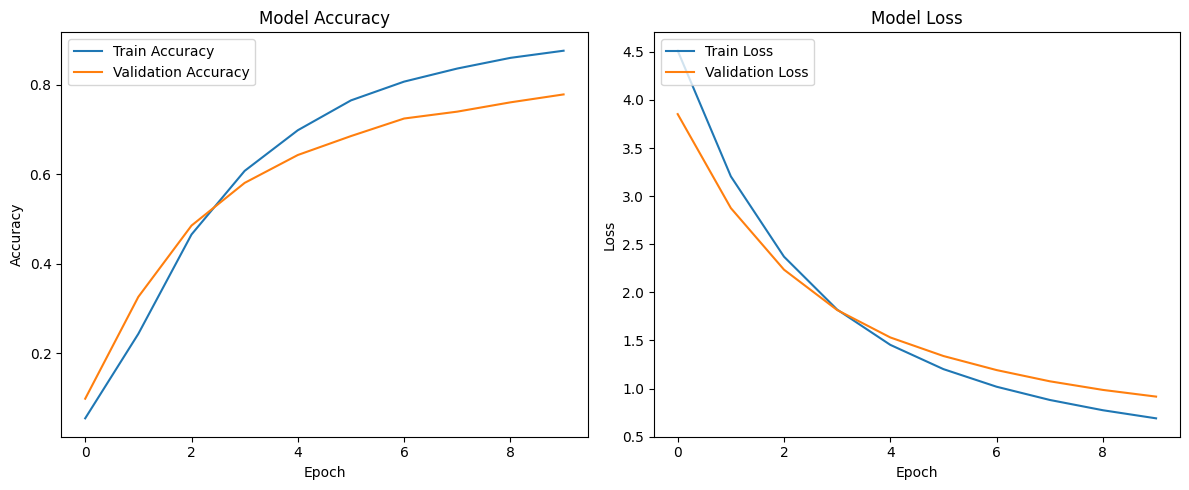

In [ ]:
plot_training_history(history_tl_nor)

### PO NORMALIZACJI REPORT:

#### CZAS:

bez: MINUTA

z: 2 MINUTY

#### WYNIK:
bez: około 80%, val_accuracy: 0.72

z: 87% dokładności, val_accuracy: 0.78

Jak widać, wyniki się znacznie polepszyły :]

## b. augumentację danych - przygotować raport porównawczy z augumentacją i bez + informacją jakie przekształcenia zostały przeprowadzone.

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [35]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

In [36]:
# augumentacja danych: polega na wprowadzeniu do materiału treningowego nieco zmodyfikowanych kopii istniejących danych:)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # normalizacja!
    rotation_range=20, # randomly rotate images through any degree between 0 and 360
    width_shift_range=0.2, # horizontal shift of image
    height_shift_range=0.2, #  the percentage of width or height of the image to shift
    zoom_range=0.2, #  zooming in
    horizontal_flip=True, # flipping along the horizontal axis
    fill_mode='nearest' # “nearest” which simply replaces the empty area with the nearest pixel values
)

In [37]:
train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [38]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history_tl_au = model.fit(train, validation_data=validation, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 305ms/step - accuracy: 0.0342 - loss: 4.9648 - val_accuracy: 0.0985 - val_loss: 3.9156
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.1585 - loss: 3.6159 - val_accuracy: 0.2862 - val_loss: 3.0237
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.3363 - loss: 2.7725 - val_accuracy: 0.4362 - val_loss: 2.4217
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.5022 - loss: 2.1689 - val_accuracy: 0.5554 - val_loss: 1.9796
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 259ms/step - accuracy: 0.6123 - loss: 1.7662 - val_accuracy: 0.6146 - val_loss: 1.6743
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.6757 - loss: 1.4858 - val_accuracy: 0.6523 - val_loss: 1.4946
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.7212 - loss: 1.2986 - val_accuracy: 0.6977 - val_loss: 1.3079
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.7517 - loss: 1

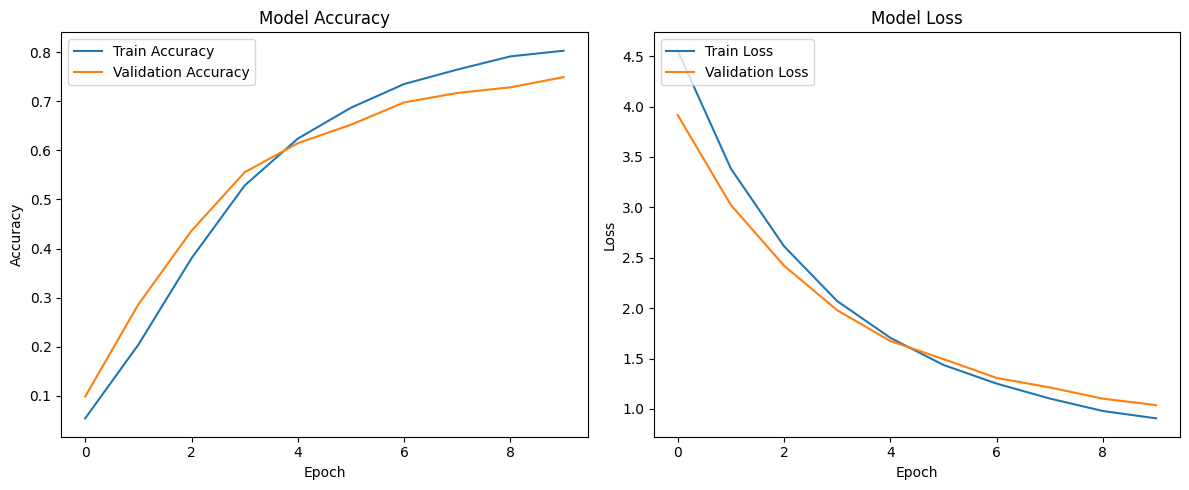

In [41]:
plot_training_history(history_tl_au)

PARAMETRY ImageDataGenerator WYTŁUMACZONE

    preprocessing_function=preprocess_input -> normalizacja, przekształca obrazy tak, by pasowały do wymagań konkretnej sieci
    rotation_range=20, -> losowo obraca obraz w zakresie od -20 do +20 stopni
    width_shift_range=0.2, -> przesuwa obraz w poziomie o maksymalnie 20% szerokości
    height_shift_range=0.2, -> przesuwa obraz w pionie o maksymalnie 20% szerokości
    zoom_range=0.2, -> zoom, zbliżenie w zakresie 20%
    horizontal_flip=True, -> obrócienie obrazu poziomo
    fill_mode='nearest' -> “nearest” zamienia powstane puste piksele obrazu najbliższymi wartościami

## REPORT AUGUMENTACJA

### CZAS:
bez: 2 minuty

z: 8 minut

### WYNIKI:

bez: 87%

z: 80%

Zajęło 4 razy więcej czasu i wyniki się pogorszyły niestety;[


## c. dropout - przygotować raport porównawczy z zastosowaniem dropoutu i bez.


In [53]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [50]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history_dropout = model.fit(train, validation_data=validation, epochs=15)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 384ms/step - accuracy: 0.0258 - loss: 8.2603 - val_accuracy: 0.0731 - val_loss: 4.0868
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 277ms/step - accuracy: 0.0975 - loss: 7.0675 - val_accuracy: 0.2069 - val_loss: 3.2500
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.2150 - loss: 6.6518 - val_accuracy: 0.3623 - val_loss: 2.6483
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 274ms/step - accuracy: 0.3302 - loss: 6.2716 - val_accuracy: 0.4692 - val_loss: 2.2493
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 278ms/step - accuracy: 0.4013 - loss: 5.9947 - val_accuracy: 0.5515 - val_loss: 1.9454
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.4618 - loss: 5.8346 - val_accuracy: 0.6162 - val_loss: 1.6830
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.4788 - loss: 6.0301 - val_accuracy: 0.6562 - val_loss: 1.5321
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - accuracy: 0.5340 - loss: 5

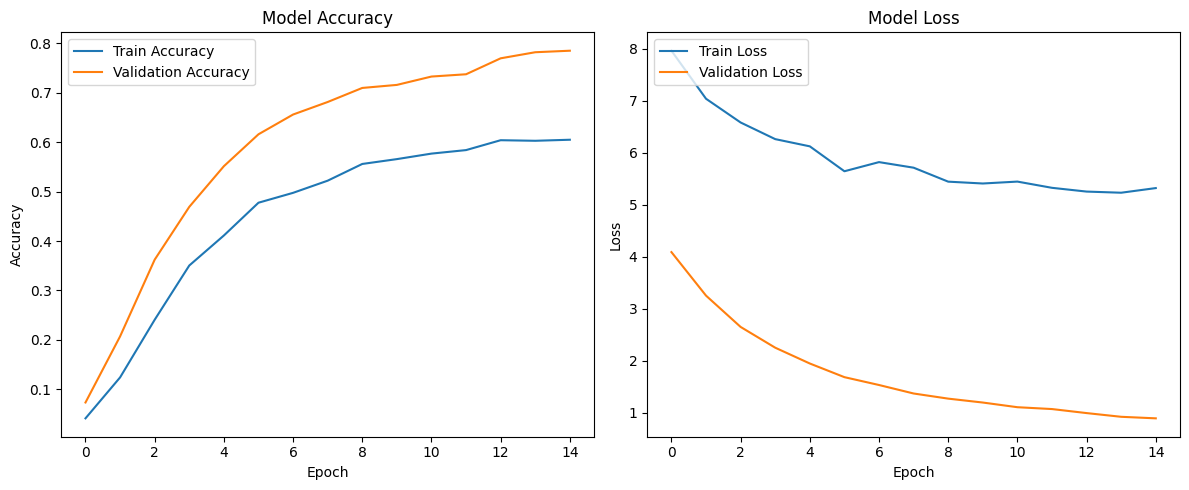

In [52]:
plot_training_history(history_dropout)

## RAPORT DROPOUT

### CZAS
BEZ: 8 minut

Z: 11 minut


### WYNIK

BEZ DROPOUT: accuracy: 80%; val_accuracy: 75%

Z: accuracy 59.6%; val_accuracy 78.5%

Taka różnica może wynikać z zastosowania warstwy Dropout, która aktywna jest tylko w trakcie treningu;

Dane walidacyjne były „czyste”, co mogło spowodować wyższą skuteczność w tym zestawie.


## d. dokładanie danych - przygotować raport porównawczy z dołożeniem nowej partii danych i bez.


In [65]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv("butterflies/Testing_set.csv"),
    directory="butterflies/test",
    x_col="filename",
    y_col=None,
    target_size=(150,150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# predykcje modelu na nowych zdjęciach
preds = model.predict(test_generator)
pred_labels = np.argmax(preds, axis=1)

labels_map = {v:k for k,v in train.class_indices.items()}
pred_labels_names = [labels_map[i] for i in pred_labels]

df_test = pd.read_csv("butterflies/Testing_set.csv")
df_test["label"] = pred_labels_names

df_test.to_csv("testing_with_labels.csv", index=False)


Found 2786 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step


In [68]:
train_df = pd.read_csv("butterflies/Training_set.csv")

pseudo_df = pd.read_csv("testing_with_labels.csv")

combined_df = pd.concat([train_df, pseudo_df], ignore_index=True)

combined_df.to_csv("combined_training.csv", index=False)

print(f"Len starego zbioru; {len(train_df)}")
print(f"Len pseudo zbioru; {len(pseudo_df)}")
print(f"Len nowego zbioru; {len(combined_df)}")

Len starego zbioru; 6499
Len pseudo zbioru; 2786
Len nowego zbioru; 9285


In [ ]:
label_distribution = combined_df['label'].value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('dystrybucja ilosci zdjec w klasach')
plt.xlabel('klasa [nazwa motyla]')
plt.ylabel('ilosc')
plt.xticks(rotation=90)
plt.show()

In [69]:
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

train_generator = img_gen.flow_from_dataframe(
    dataframe=combined_df,
    directory="butterflies/train",
    x_col="filename",
    y_col="label",
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)


Found 9285 validated image filenames belonging to 75 classes.


In [77]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [78]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_data_history = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.0265 - loss: 4.8974 - val_accuracy: 0.0962 - val_loss: 3.8473
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.1422 - loss: 3.6143

In [ ]:
plot_training_history(new_data_history)

## DOKŁADANIE DANYCH

Zastosowałam "sztuczne" dokładanie danych; jako, że instnieje folder 'test' (nieużywany) w bazie danych zdjęć ale bez labeli, użyłam modelu (z największym accuracy do tej pory) aby przewidzieć klasy zdjęć (motyli). Później stworzyłam dataframe z nazwami tych zdjęć i ich przewidzianymi labelami i połączyłam dwa datasety ze sobą, ten używany dotychczas i sztuczny.

## e. różne rozmiary wejściowe (np. 96x96, 160x160, 224x224) - przygotować raport porównawczy dla każdego rozmiaru.


## f. różny rozmiar Batch size (np. 32, 64, 128) - przygotować raport porównawczy dla każdego rozmiaru.


## g. różne struktury sieci (np. VGG16, ResNet101, InceptionV3, MobileNet) - przygotować raport porównawczy dla każdej sieci (min. 4).